# Nonnegative least square
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We are interested in the nonnegative least square problem
\begin{align*}
\min_x &\, \phi(x):= ||Ax-b||^2\\
    & \text{subj. to } x \geq 0.
\end{align*}
Alternatively, we can write it as 
$$\min_x \frac 1 2 ||Ax-b||^2 + \delta_{x\geq 0}=: f(Ax)+g(x)$$
or in a primal-dual form
$$\min_x \max_y g(x)+(Ax,y)-f^*(y),$$
where $f(x) = \frac 1 2 ||x-b||^2$, $f^*(y) = \frac 1 2 ||y||^2 + (b,y) = \frac 1 2 ||y+b||^2 -\frac{1}{2}||b||^2$, $g(x) = \delta_{\R^n_+}(x)$.

In order to apply proximal gradient method of FISTA we have to define $h(x) = f(Ax) = \frac 1 2 ||Ax-b||^2$. Then $\nabla h(x) = A^*(Ax-b)$.

In [4]:
import scipy.sparse as spr
import scipy.sparse.linalg as la

from opt_operators import *
from algorithms import *
from pd_algorithms import *
from misc_for_output import *
%reload_ext autoreload
%autoreload 2

In [5]:
gen = 100

Choose any instance of the problems below

In [6]:
n = 4000
m = 2000
A = np.random.uniform(-1,1,(m,n))
s = 1000

# for this problem we took beta = 25

In [3]:
n = 2000
m = 1000
A = spr.rand(m,n, 0.5, 'csr')
s = 100

# for this problem we took beta = 25

In [17]:
gen = 100

n = 5000
m = 3000
A = spr.rand(m,n, 0.1, 'csr')
s = 100

# for this problem we took beta = 25

In [27]:
n = 20000
m = 10000
rvs = lambda x: np.random.normal(0,1, x)
A = spr.random(m,n, 0.01, 'csr', data_rvs=rvs)
s = 500

# for this problem we took beta = 1

Set $w$ and $b = Aw$. By this, the optimal objective value $\phi_*$ is $0$.

In [7]:
w = np.random.uniform(0,100, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)
b = A.dot(w)































































































Define all proximal operators, energy $J$, and gradient $\nabla h$ for proximal gradient-like methods

In [8]:
def prox_g(x, rho):
    return np.fmax(x, 0)

def prox_f_conj(y, rho):
    return (y - rho*b)/(1+rho)

def J(x,y):
    t = A.dot(x)-b
    return 0.5*t.dot(t)

# We need the following in order to apply accelerated primal-dual with strongly convex primal term.
def J1(y,x):
    return J(x,y)

#### for FISTA
def h(x):
    t = A.dot(x)-b
    return 0.5 * t.dot(t)

def dh(x):
    return A.T.dot(A.dot(x)-b)

def F(x):
    return J(x,1)

Compute matrix norm (expensive in general) and Frobenius norm (cheap)

In [10]:
# find the largest eigenvalue:

max_eig = (np.max(LA.eigh(A.dot(A.T))[0]))  # for dense matrix
#max_eig = np.real((la.eigs(A.dot(A.T), k=1)[0]))[0] # for sparse matrix

# find matrix norm
L = np.sqrt(max_eig)
print(1./L)

# find Frobenius norm (this is very cheap)
L_F = LA.norm(A) # for dense matrix
#L_F = la.norm(A, 'fro') #  for sparse matrix


0.0160602032569


Define number of iterations, initial points, and initial step sizes

In [11]:
x0 = np.zeros(n)
y0 = -b

# for PDA
tau = 1./L
sigma = 1./L

alpha = 1./L**2 # for FISTA
tau0 = np.sqrt(min(m,n))/L_F  # for PDAL

Set number of iterations $N$ and run the algorithms. Choose a proper ratio between $\tau$ and $\sigma$

In [12]:
N = 2000

ans1 = pd(J, prox_g, prox_f_conj, A, x0, y0, 5*sigma, 1./5*tau, numb_iter=N)
ans2 = pd_linesearch_dual_is_square_norm(J, prox_g, -b, A, x0, y0, tau0, 25, numb_iter=N)
ans3 = pd_accelerated_primal(J1, prox_f_conj, prox_g, -A.T, y0, x0, 1.*tau, 1.*sigma, 0.1,   numb_iter=N)
ans4 = pd_linesearch_acceler_dual_is_square_norm(J, prox_g, -b, A,  x0, y0, tau0, 1, gamma=0.1, numb_iter=N)
ans5 = fista(F, dh, prox_g, x0, alpha, numb_iter=N)
ans6 = sparsa(F, h, dh, prox_g, x0, alpha, numb_iter=N, time_bound=300)

----- Primal-dual method -----
Time execution: 174.386257
----- Primal-dual method with  linesearch. f^*(y)=0.5*||y-b||^2-----
Time execution: 176.28608270599997
----- Accelerated primal-dual method (g(x) is strongly convex)-----
Time execution: 171.771255403
----- Accelerated primal-dual method with  linesearch for dual f^*(y)=0.5*||y-b||^2-----
Time execution: 175.43923289099996
---- FISTA----
Time execution: 172.2978864490001


Quick results:

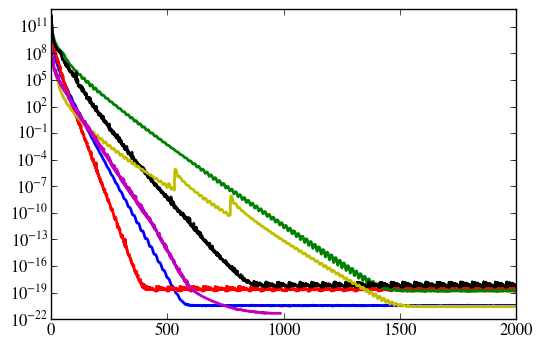

In [13]:
plt.plot(ans1[1], 'b',)
plt.plot(ans2[1], 'r',)
plt.plot(ans3[1], 'g',)
plt.plot(ans4[1], 'k',)
plt.plot(ans5[1], 'y',)
plt.plot(ans6[1], 'm')

plt.yscale('log')
plt.show()

Define all labels and define the time stamp (in seconds) $-$ the moment to which we want to present our results

In [14]:
answers = [ans1, ans2, ans3, ans4, ans5, ans6]
alg = ["PDA", "PDAL", "APDA", "APDAL",  "FISTA", "SPARSA"]

time_stamp = 150

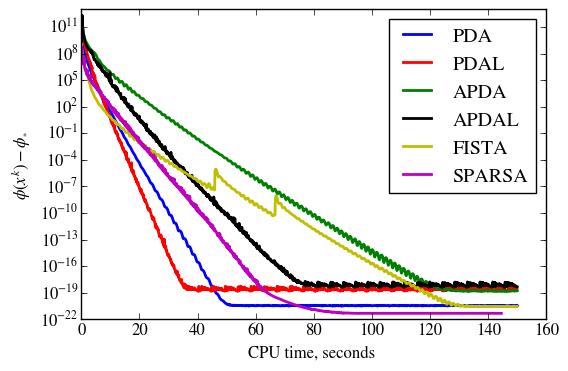

In [15]:
a1,a2 = cut_time(ans1[0],ans1[1], t=time_stamp)
b1,b2 = cut_time(ans2[0],ans2[1], t=time_stamp)
c1,c2 = cut_time(ans3[0],ans3[1], t=time_stamp)
d1,d2 = cut_time(ans4[0],ans4[1], t=time_stamp)
e1,e2 = cut_time(ans5[0],ans5[1], t=time_stamp)
f1,f2 = cut_time(ans6[0],ans6[1], t=time_stamp)

plt.plot(a1, a2, 'b', label=alg[0])
plt.plot(b1, b2, 'r', label=alg[1])
plt.plot(c1, c2, 'g', label=alg[2])
plt.plot(d1, d2, 'k', label=alg[3])
plt.plot(e1, e2, 'y', label=alg[4])
plt.plot(f1, f2, 'm', label=alg[5])

plt.yscale('log')
plt.xlabel(u'CPU time, seconds ')
plt.ylabel('$\phi(x^k)-\phi_{_*}$')
plt.legend()
plt.savefig('figures/nneg-?.pdf',bbox_inches='tight')
plt.show()
plt.clf()